#### Fitting method for electronegative plasma
<hr/>

Control Variables : <font color = 'sky blue'> $n_e,n_+,n_-,T_e, T_+,T_-, m_+,m_-$ </font>


<font size="2">
    [1] <a href="https://aip.scitation.org/doi/10.1063/1.4802252"> [2013] Langmuir probe analysis of highly electronegative plasmas</a> <br>
    [2] <a href="https://doi.org/10.1063/1.4903328"> [2014] Langmuir probe analysis in electronegative plasmas</a> <br><br>
<hr/>

Number of control variables can be reduced by set $m_+,m_-$ and $n_+ =n_e+n_-$. We just need 5 variables for fitting<br>
Ion composition setup : $SF_5^+,SF_5^-$ and m=127 AMU<br>
Fitting error within 5%

<hr/>

Import Modules

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.special import erfc
from setup import *

Probe Setup & Ion Mass

In [24]:
print("\033[94m\tProbe Setup\033[0m")
print("\tProbe Radius : \033[31m{:.3f}\033[0m [mm]\n\tProbe Length : \033[31m{:.3f}\033[0m [mm]\n".format(PROBE_RADIUS*1e3,PROBE_LENGTH*1e3))
print("\033[94m\tIon Mass\033[0m")
print("\tPositive : \033[31m{}\033[0m [amu]\n\tNegative : \033[31m{}\033[0m [amu]".format(POSITIVE_ION_MASS/1.67e-27,NEGATIVE_ION_MASS/1.67e-27))

	Probe Setup
	Probe Radius : 0.025 [mm]
	Probe Length : 6.000 [mm]

	Ion Mass
	Positive : 127.0 [amu]
	Negative : 127.0 [amu]


Sheath Calculation

In [33]:
def solve_alpha_s(Te, Tm, alpha_0):
    return np.max(fsolve(lambda alpha_s : alpha_0 - alpha_s*np.exp(-1/2*(1 + alpha_s)/(1 + Te/Tm*alpha_s)*(1 - Te/Tm)) \
            ,np.logspace(-4, 2, 7)))

def cylindrical_sheath(uB, J, V):
    R = 20*PROBE_RADIUS
    r_list = np.linspace(R, PROBE_RADIUS, 30000)
    def fun2(y, r):
        return [R*J/(r*EPSILON_0*y[1]) - y[0]/r, ELECTRON_CHARGE*y[0]/(POSITIVE_ION_MASS*y[1])]   # y는 E, u 로 이루어져있음

    sol = odeint(fun2, y0=[0, uB], t=r_list)  # Sheath edge로 추정되는 부분에서 적분 시작
    u = sol[:, 1]
    E = sol[:, 0]
    Va = np.sqrt(2*ELECTRON_CHARGE*V/POSITIVE_ION_MASS)
    f_linear = interp1d(u, r_list, fill_value='extrapolate')
    return R - f_linear(Va)

def planar_sheath(J, V):
    r_sh = np.sqrt(4/9*EPSILON_0*np.sqrt(2*ELECTRON_CHARGE/POSITIVE_ION_MASS)*(abs(V))**1.5/J)
    return r_sh

def solve_Seff(V, n_e, n_m, Te, Tm, Vp, cylindrical=True):
    n_p = n_e + n_m
    a_s = solve_alpha_s(Te, Tm, n_m/n_e)
    uBp = np.sqrt(ELECTRON_CHARGE*Te/POSITIVE_ION_MASS)*np.sqrt((1+a_s)/(1+Te/Tm*a_s))
    J = H_FACTOR*n_p*ELECTRON_CHARGE*uBp

    if cylindrical:
        r_sh = cylindrical_sheath(uBp, J, abs(V-Vp)) + PROBE_RADIUS #r_sh calculation with cylindrical probe
        return 2*np.pi*r_sh*PROBE_LENGTH + 2*np.pi*r_sh**2

    else:
        r_sh = planar_sheath(J, abs(V-Vp)) #r_sh calculation with planar probe
        return np.pi*PROBE_RADIUS**2 + 2*np.pi*PROBE_RADIUS*r_sh

Current Calculation

In [34]:
def I_p(V, n_e, n_m, Te, Tp, Tm, Vp):
    n_p = n_e + n_m
    a_s = solve_alpha_s(Te, Tm, n_m/n_e)
    uBp = np.sqrt(ELECTRON_CHARGE*Te/POSITIVE_ION_MASS)*np.sqrt((1+a_s)/(1+Te/Tm*a_s))
    if Vp > V:
        I_Vp = H_FACTOR*n_p*ELECTRON_CHARGE*uBp*solve_Seff(Vp, n_e, n_m, Te, Tm, Vp)
        I = 2*I_Vp - H_FACTOR*n_p*ELECTRON_CHARGE*uBp*solve_Seff(V, n_e, n_m, Te, Tm, Vp)
    else:
        I_Vp = H_FACTOR*n_p*ELECTRON_CHARGE*uBp*solve_Seff(V, n_e, n_m, Te, Tm, Vp)
        I = I_Vp*np.exp(-(V-Vp)/Tp)
    return I
    
def I_e(V, n_e, Te, Vp):
    ve = np.sqrt(8*ELECTRON_CHARGE*Te/np.pi/ELECTRON_MASS)
    if Vp > V:
        I = ELECTRON_CHARGE*PROBE_AREA*n_e*ve/4*np.exp(-(Vp - V)/Te)
    else:
        I = ELECTRON_CHARGE*PROBE_AREA*n_e*ve/2*(2*np.sqrt((V-Vp)/Te/np.pi)+1/2*np.exp((V-Vp)/Te)*erfc((V-Vp)/Te))
    return I
    
def I_n(V, n_e, n_m, Te, Tm, Vp):
    uBn = np.sqrt(ELECTRON_CHARGE*Tm/NEGATIVE_ION_MASS)

    if Vp > V:
        I_Vp = H_FACTOR*n_m*ELECTRON_CHARGE*uBn*solve_Seff(V, n_e, n_m, Te, Tm, Vp) # Seff(V) function 만들기
        I = I_Vp*np.exp(-(Vp - V)/Tm)
        #print('I: {:.4e}'.format(I))
    else:
        I_Vp = H_FACTOR*n_m*ELECTRON_CHARGE*uBn*solve_Seff(Vp, n_e, n_m, Te, Tm, Vp)
        I = 2*I_Vp - H_FACTOR*n_m*ELECTRON_CHARGE*uBn*solve_Seff(V, n_e, n_m, Te, Tm, Vp)
        #print('I: {:.4e}'.format(I))
    return I

In [48]:
Vp = 0
ne = 1e15
nm = 1e16
Te = 2
Tp = 0.3
Tm = 0.2

In [51]:
V_list = np.linspace(-10,10,500)
I_list, I_p_list, I_e_list, I_n_list = [], [], [], []

for V in V_list:
    I_p_list.append(-I_p(V, ne, nm, Te, Tp, Tm, Vp))
    I_e_list.append(I_e(V, ne, Te, Vp))
    I_n_list.append(I_n(V, ne, nm, Te, Tm, Vp))
    I_list.append(-I_p(V, ne, nm, Te, Tp, Tm, Vp) + I_e(V, ne, Te, Vp) + I_n(V, ne, nm, Te, Tm, Vp))

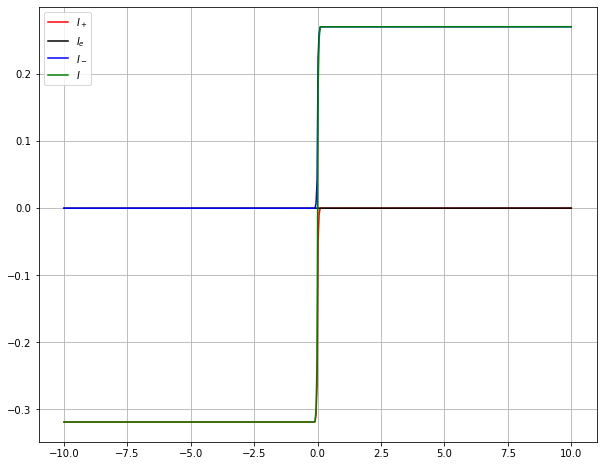

In [52]:
plt.figure(figsize=(10, 8))
plt.plot(V_list, I_p_list, c='r')
plt.plot(V_list, I_e_list, c='k')
plt.plot(V_list, I_n_list, c='b')
plt.plot(V_list, I_list, c='g')
plt.grid(1)
plt.legend(['$I_+$', '$I_e$', '$I_-$', '$I$'])